In [2]:
from feature_functions import *

In [ ]:
controlFiles, patientFiles = fileClassification()

In [ ]:
# CALCULATE ALL STATIC FEATURES AND PUT INTO DATAFRAME

static_subject_id = [] 
static_category = [] 
static_mean_vel = [] 
static_max_vel = [] 
static_vel_std = []
static_nvv = []  
static_vel_niv = [] #rate 
static_mean_accel = [] 
static_max_accel = [] 
static_std_accel = [] 
static_nia = [] #rate 
static_mean_jerk = []  
static_max_jerk = [] 
static_std_jerk = [] 
static_nij = [] #rate 
static_duration = [] 
static_nic = [] 
static_mean_pressure = [] 
static_max_pressure = [] 
static_std_pressure = [] 
static_rate_ip = [] 
static_x_entropy = [] 
static_y_entropy = [] 
static_x_skewness = [] 
static_y_skewness = [] 
static_x_kurtosis = [] 
static_y_kurtosis = [] 
static_vel_skewness = [] 
static_vel_kurtosis = [] 
static_accel_skewness = [] 
static_accel_kurtosis = [] 
static_jerk_skewness = [] 
static_jerk_kurtosis = [] 
static_pressure_skewness = [] 
static_pressure_kurtosis = [] 
static_curv_skewness = [] 
static_curv_kurtosis = [] 
static_pressure_high_freq = [] 
static_pressure_low_freq = [] 
static_pressure_bandpass_freq = [] 
static_altitude_high_freq = [] 
static_altitude_low_freq = [] 
static_altitude_bandpass_freq = [] 
static_pressure_reg_r2 = [] 
static_pressure_reg_x0 = [] 
static_pressure_reg_x1 = [] 
static_pressure_reg_sumresids = [] 
static_curv_reg_r2 = [] 
static_curv_reg_x0 = [] 
static_curv_reg_x1 = [] 
static_curv_reg_sumresids = [] 
static_vel_reg_r2 = [] 
static_vel_reg_x0 = [] 
static_vel_reg_x1 = [] 
static_vel_reg_sumresids = [] 

static_VR_reg_r2 = [] 
static_VR_reg_x0 = [] 
static_VR_reg_x1 = [] 
static_VR_reg_sumresids = [] 
static_CV_reg_r2 = [] 
static_CV_reg_x0 = [] 
static_CV_reg_x1 = [] 
static_CV_reg_sumresids = [] 
static_RT_reg_r2 = [] 
static_RT_reg_x0 = [] 
static_RT_reg_x1 = [] 
static_RT_reg_sumresids = [] 
static_rdot_mean = [] 
static_rdot_std = [] 
static_tdot_mean = [] 
static_tdot_std = [] 
static_rdotdot_mean = [] 
static_rdotdot_std = [] 
static_tdotdot_mean = [] 
static_tdotdot_std = [] 
static_drdtheta_mean = [] 
static_drdtheta_std = [] 

static_pressure_rising_duration = [] 
static_pressure_rising_range = [] 
static_pressure_falling_duration = []
static_pressure_falling_range = [] 

for filename in controlFiles:
    print(filename)
    # retrieve all preprocessed data
    
    (static_time, static_x, static_y, static_radius, static_theta, static_velocity, static_acceleration, 
    static_jerk, static_rdot, static_tdot, static_rdotdot, static_tdotdot, static_drdtheta, static_curvature, 
    static_pressure, static_risingIndex, static_fallingIndex, static_pressure_rising, static_pressure_main, 
    static_pressure_falling, static_altitude) = static_preprocessing(filename)

    (a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z,
    a1,b1,c1,d1,e1,f1,g1,h1,i1,j1,k1,l1,m1,n1,o1,p1,q1,r1,s1,t1,u1,v1,w1,x1,y1,z1,
    a2,b2,c2,d2,e2,f2,g2,h2,i2,j2,k2,l2,m2,n2,o2,p2,q2,r2,s2,t2,u2,v2,w2,x2,y2,z2,
    a3) = static_calculate(filename)

    # 0 is for control
    static_category.append(0)
    static_subject_id.append(filename)
    static_mean_vel.append(a)
    static_max_vel.append(b)
    static_vel_std.append(c)
    static_nvv.append(d)
    static_vel_niv.append(e) # rate
    static_mean_accel.append(f)
    static_max_accel.append(g)
    static_std_accel.append(h)
    static_nia.append(i) #rate
    static_mean_jerk.append(j)
    static_max_jerk.append(k)
    static_std_jerk.append(l)
    static_nij.append(m) #rate
    static_duration.append(n)
    static_nic.append(o)
    static_mean_pressure.append(p)
    static_max_pressure.append(q)
    static_std_pressure.append(r)
    static_rate_ip.append(s)
    static_x_entropy.append(t)
    static_y_entropy.append(u)
    static_x_skewness.append(v)
    static_y_skewness.append(w)
    static_x_kurtosis.append(x)
    static_y_kurtosis.append(y)
    static_vel_skewness.append(z)
    static_vel_kurtosis.append(a1)
    static_accel_skewness.append(b1)
    static_accel_kurtosis.append(c1)
    static_jerk_skewness.append(d1)
    static_jerk_kurtosis.append(e1)
    static_pressure_skewness.append(f1)
    static_pressure_kurtosis.append(g1)
    static_curv_skewness.append(h1)
    static_curv_kurtosis.append(i1)
    static_pressure_high_freq.append(j1)
    static_pressure_low_freq.append(k1)
    static_pressure_bandpass_freq.append(l1)
    static_altitude_high_freq.append(m1)
    static_altitude_low_freq.append(n1)
    static_altitude_bandpass_freq.append(o1)
    static_pressure_reg_r2.append(p1)
    static_pressure_reg_x0.append(q1)
    static_pressure_reg_x1.append(r1)
    static_pressure_reg_sumresids.append(s1)
    static_curv_reg_r2.append(t1)
    static_curv_reg_x0.append(u1)
    static_curv_reg_x1.append(v1)
    static_curv_reg_sumresids.append(w1)
    static_vel_reg_r2.append(x1)
    static_vel_reg_x0.append(y1)
    static_vel_reg_x1.append(z1)
    static_vel_reg_sumresids.append(a2)

    static_VR_reg_r2.append(b2)
    static_VR_reg_x0.append(c2)
    static_VR_reg_x1.append(d2)
    static_VR_reg_sumresids.append(e2)
    static_CV_reg_r2.append(f2)
    static_CV_reg_x0.append(g2)
    static_CV_reg_x1.append(h2)
    static_CV_reg_sumresids.append(i2)
    static_RT_reg_r2.append(j2)
    static_RT_reg_x0.append(k2)
    static_RT_reg_x1.append(l2)
    static_RT_reg_sumresids.append(m2)
    static_rdot_mean.append(n2)
    static_rdot_std.append(o2)
    static_tdot_mean.append(p2)
    static_tdot_std.append(q2)
    static_rdotdot_mean.append(r2)
    static_rdotdot_std.append(s2)
    static_tdotdot_mean.append(t2)
    static_tdotdot_std.append(u2)
    static_drdtheta_mean.append(v2)
    static_drdtheta_std.append(w2)

    static_pressure_rising_duration.append(x2)
    static_pressure_rising_range.append(y2)
    static_pressure_falling_duration.append(z2)
    static_pressure_falling_range.append(a3)

    
for filename in patientFiles:
    print(filename)
    # retrieve all preprocessed data
    (static_time, static_x, static_y, static_radius, static_theta, static_velocity, static_acceleration, 
    static_jerk, static_rdot, static_tdot, static_rdotdot, static_tdotdot, static_drdtheta, static_curvature, 
    static_pressure, static_risingIndex, static_fallingIndex, static_pressure_rising, static_pressure_main, 
    static_pressure_falling, static_altitude) = static_preprocessing(filename)
    
    (a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z,
    a1,b1,c1,d1,e1,f1,g1,h1,i1,j1,k1,l1,m1,n1,o1,p1,q1,r1,s1,t1,u1,v1,w1,x1,y1,z1,
    a2,b2,c2,d2,e2,f2,g2,h2,i2,j2,k2,l2,m2,n2,o2,p2,q2,r2,s2,t2,u2,v2,w2,x2,y2,z2,
    a3) = static_calculate(filename)

    # 1 is for patient
    static_category.append(1)
    static_subject_id.append(filename)
    static_mean_vel.append(a)
    static_max_vel.append(b)
    static_vel_std.append(c)
    static_nvv.append(d)
    static_vel_niv.append(e) # rate
    static_mean_accel.append(f)
    static_max_accel.append(g)
    static_std_accel.append(h)
    static_nia.append(i) #rate
    static_mean_jerk.append(j)
    static_max_jerk.append(k)
    static_std_jerk.append(l)
    static_nij.append(m) #rate
    static_duration.append(n)
    static_nic.append(o)
    static_mean_pressure.append(p)
    static_max_pressure.append(q)
    static_std_pressure.append(r)
    static_rate_ip.append(s)
    static_x_entropy.append(t)
    static_y_entropy.append(u)
    static_x_skewness.append(v)
    static_y_skewness.append(w)
    static_x_kurtosis.append(x)
    static_y_kurtosis.append(y)
    static_vel_skewness.append(z)
    static_vel_kurtosis.append(a1)
    static_accel_skewness.append(b1)
    static_accel_kurtosis.append(c1)
    static_jerk_skewness.append(d1)
    static_jerk_kurtosis.append(e1)
    static_pressure_skewness.append(f1)
    static_pressure_kurtosis.append(g1)
    static_curv_skewness.append(h1)
    static_curv_kurtosis.append(i1)
    static_pressure_high_freq.append(j1)
    static_pressure_low_freq.append(k1)
    static_pressure_bandpass_freq.append(l1)
    static_altitude_high_freq.append(m1)
    static_altitude_low_freq.append(n1)
    static_altitude_bandpass_freq.append(o1)
    static_pressure_reg_r2.append(p1)
    static_pressure_reg_x0.append(q1)
    static_pressure_reg_x1.append(r1)
    static_pressure_reg_sumresids.append(s1)
    static_curv_reg_r2.append(t1)
    static_curv_reg_x0.append(u1)
    static_curv_reg_x1.append(v1)
    static_curv_reg_sumresids.append(w1)
    static_vel_reg_r2.append(x1)
    static_vel_reg_x0.append(y1)
    static_vel_reg_x1.append(z1)
    static_vel_reg_sumresids.append(a2)

    static_VR_reg_r2.append(b2)
    static_VR_reg_x0.append(c2)
    static_VR_reg_x1.append(d2)
    static_VR_reg_sumresids.append(e2)
    static_CV_reg_r2.append(f2)
    static_CV_reg_x0.append(g2)
    static_CV_reg_x1.append(h2)
    static_CV_reg_sumresids.append(i2)
    static_RT_reg_r2.append(j2)
    static_RT_reg_x0.append(k2)
    static_RT_reg_x1.append(l2)
    static_RT_reg_sumresids.append(m2)
    static_rdot_mean.append(n2)
    static_rdot_std.append(o2)
    static_tdot_mean.append(p2)
    static_tdot_std.append(q2)
    static_rdotdot_mean.append(r2)
    static_rdotdot_std.append(s2)
    static_tdotdot_mean.append(t2)
    static_tdotdot_std.append(u2)
    static_drdtheta_mean.append(v2)
    static_drdtheta_std.append(w2)

    static_pressure_rising_duration.append(x2)
    static_pressure_rising_range.append(y2)
    static_pressure_falling_duration.append(z2)
    static_pressure_falling_range.append(a3)

df_all_features_static = pd.DataFrame({'Static Subject ID': static_subject_id, 'Category': static_category,
'Mean Velocity': static_mean_vel, 'Max Velocity': static_max_vel, 'Velocity Std': static_vel_std, 'NVV': static_nvv, 'NIV': static_vel_niv,
'Mean Acceleration': static_mean_accel, 'Max Acceleration': static_max_accel, 'Accleration Std': static_std_accel, 'NIA': static_nia,
'Mean Jerk': static_mean_jerk, 'Max Jerk': static_max_jerk, 'Jerk Std': static_std_jerk, 'NIJ': static_nij, 
'Duration': static_duration, 'NIC': static_nic,
'Mean Pressure': static_mean_pressure, 'Max Pressure': static_max_pressure, 'Pressure Std': static_std_pressure, 'Rate of Inversion in Pressure': static_rate_ip,
'X Entropy': static_x_entropy, 'Y Entropy': static_y_entropy, 
'X Skewness': static_x_skewness, 'Y Skewness': static_y_skewness, 'X Kurtosis': static_x_kurtosis, 'Y Kurtosis': static_y_kurtosis,
'Vel Skewness': static_vel_skewness, 'Vel Kurtosis': static_vel_kurtosis, 'Accel Skewness': static_accel_skewness, 'Accel Kurtosis': static_accel_kurtosis,
'Jerk Skewness': static_jerk_skewness, 'Jerk Kurtosis': static_jerk_kurtosis, 
'Pressure Skewness': static_pressure_skewness, 'Pressure Kurtosis': static_pressure_kurtosis,
'Curvature Skewness': static_curv_skewness, 'Curvature Kurtosis': static_curv_kurtosis,
'Pressure High Freq': static_pressure_high_freq, 'Pressure Low Freq': static_pressure_low_freq, 'Pressure Bandpass Freq': static_pressure_bandpass_freq,
'Altitude High Freq': static_altitude_high_freq, 'Altitude Low Freq': static_altitude_low_freq, 'Altitude Bandpass Freq': static_altitude_bandpass_freq,
'Pressure Reg R^2': static_pressure_reg_r2, 'Pressure Reg x0': static_pressure_reg_x0, 'Pressure Reg x1': static_pressure_reg_x1, 'Pressure Reg SumResids': static_pressure_reg_sumresids,
'Curv Reg R^2': static_curv_reg_r2, 'Curv Reg x0': static_curv_reg_x0, 'Curv Reg x1': static_curv_reg_x1, 'Curv Reg SumResids': static_curv_reg_sumresids,
'Vel Reg R^2': static_vel_reg_r2, 'Vel Reg x0': static_vel_reg_x0, 'Vel Reg x1': static_vel_reg_x1, 'Vel Reg SumResids': static_vel_reg_sumresids,
'VR Reg R^2': static_VR_reg_r2, 'VR Reg x0': static_VR_reg_x0, 'VR Reg x1': static_VR_reg_x1, 'VR Reg SumResids': static_VR_reg_sumresids, 
'CV Reg R^2': static_CV_reg_r2, 'CV Reg x0': static_CV_reg_x0, 'CV Reg x1': static_CV_reg_x1, 'CV Reg SumResids': static_CV_reg_sumresids, 
'RT Reg R^2': static_RT_reg_r2, 'RT Reg x0': static_RT_reg_x0, 'RT Reg x1': static_RT_reg_x1, 'RT Reg SumResids': static_RT_reg_sumresids, 
'R Dot Mean': static_rdot_mean, 'R Dot STD': static_rdot_std, 'T Dot Mean': static_tdot_mean, 'T Dot STD': static_tdot_std, 
'R dotdot Mean': static_rdotdot_mean, 'R dotdot STD': static_rdotdot_std, 'T dotdot Mean': static_tdotdot_mean, 'T dotdot STD': static_tdotdot_std, 
'drdtheta Mean': static_drdtheta_mean, 'drdtheta STD': static_drdtheta_std, 
'Pressure Rising Duration': static_pressure_rising_duration, 'Pressure Rising Range': static_pressure_rising_range,
'Pressure Falling Duration': static_pressure_falling_duration, 'Pressure Falling Range': static_pressure_falling_range})

/work/ParkinsonHW/C_0001.txt
/work/feature_functions.py:188: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde = KernelDensity(kernel='gaussian', bandwidth=10).fit(data[:, None])
/work/feature_functions.py:189: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  logprob = kde.score_samples(data[:, None])
/work/feature_functions.py:188: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde = KernelDensity(kernel='gaussian', bandwidth=10).fit(data[:, None])
/work/feature_functions.py:189: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be re

In [ ]:
df_all_features_static.to_csv('Static_HW_features.csv', index = False, header=True)

![Picture title](image-20210411-135602.png)

In [ ]:
for i in df_all_features_static.columns[2:]: 
    plt.figure(figsize = (4, 4))
    #plt.title('Strip Plot of {} vs. Category (0 - Control; 1 - Patient)'.format(i), fontsize = 15)
    sns.stripplot(x = df_all_features_static['Category'], y = df_all_features_static[i])

In [ ]:
# CALCULATE ALL DYNAMIC FEATURES AND PUT INTO DATAFRAME

dynamic_subject_id = []
dynamic_category = []
dynamic_mean_vel = []
dynamic_max_vel = []
dynamic_vel_std = []
dynamic_nvv = []
dynamic_vel_niv = [] #rate
dynamic_mean_accel = []
dynamic_max_accel = []
dynamic_std_accel = []
dynamic_nia = [] #rate
dynamic_mean_jerk = []
dynamic_max_jerk = []
dynamic_std_jerk = []
dynamic_nij = [] #rate
dynamic_duration = []
dynamic_nic = []
dynamic_mean_pressure = []
dynamic_max_pressure = []
dynamic_std_pressure = []
dynamic_rate_ip = []
dynamic_x_entropy = []
dynamic_y_entropy = []
dynamic_x_skewness = []
dynamic_y_skewness = []
dynamic_x_kurtosis = []
dynamic_y_kurtosis = []
dynamic_vel_skewness = []
dynamic_vel_kurtosis = []
dynamic_accel_skewness = []
dynamic_accel_kurtosis = []
dynamic_jerk_skewness = []
dynamic_jerk_kurtosis = []
dynamic_pressure_skewness = []
dynamic_pressure_kurtosis = []
dynamic_curv_skewness = []
dynamic_curv_kurtosis = []
dynamic_pressure_high_freq = []
dynamic_pressure_low_freq = []
dynamic_pressure_bandpass_freq = []
dynamic_altitude_high_freq = []
dynamic_altitude_low_freq = []
dynamic_altitude_bandpass_freq = []
dynamic_pressure_reg_r2 = []
dynamic_pressure_reg_x0 = []
dynamic_pressure_reg_x1 = []
dynamic_pressure_reg_sumresids = []
dynamic_curv_reg_r2 = []
dynamic_curv_reg_x0 = []
dynamic_curv_reg_x1 = []
dynamic_curv_reg_sumresids = []
dynamic_vel_reg_r2 = []
dynamic_vel_reg_x0 = []
dynamic_vel_reg_x1 = []
dynamic_vel_reg_sumresids = []

dynamic_VR_reg_r2 = []
dynamic_VR_reg_x0 = []
dynamic_VR_reg_x1 = []
dynamic_VR_reg_sumresids = []
dynamic_CV_reg_r2 = []
dynamic_CV_reg_x0 = []
dynamic_CV_reg_x1 = []
dynamic_CV_reg_sumresids = []
dynamic_RT_reg_r2 = []
dynamic_RT_reg_x0 = []
dynamic_RT_reg_x1 = []
dynamic_RT_reg_sumresids = []
dynamic_rdot_mean = []
dynamic_rdot_std = []
dynamic_tdot_mean = []
dynamic_tdot_std = []
dynamic_rdotdot_mean = []
dynamic_rdotdot_std = []
dynamic_tdotdot_mean = []
dynamic_tdotdot_std = []
dynamic_drdtheta_mean = []
dynamic_drdtheta_std = []

dynamic_pressure_rising_duration = []
dynamic_pressure_rising_range = []
dynamic_pressure_falling_duration = []
dynamic_pressure_falling_range = []

for filename in controlFiles:
    print(filename)
    # retrieve all preprocessed data

    (dynamic_time, dynamic_x, dynamic_y, dynamic_radius, dynamic_theta, dynamic_velocity, dynamic_acceleration,
    dynamic_jerk, dynamic_rdot, dynamic_tdot, dynamic_rdotdot, dynamic_tdotdot, dynamic_drdtheta, dynamic_curvature,
    dynamic_pressure, dynamic_risingIndex, dynamic_fallingIndex, dynamic_pressure_rising, dynamic_pressure_main,
    dynamic_pressure_falling, dynamic_altitude) = dynamic_preprocessing(filename)

    (a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z,
    a1,b1,c1,d1,e1,f1,g1,h1,i1,j1,k1,l1,m1,n1,o1,p1,q1,r1,s1,t1,u1,v1,w1,x1,y1,z1,
    a2,b2,c2,d2,e2,f2,g2,h2,i2,j2,k2,l2,m2,n2,o2,p2,q2,r2,s2,t2,u2,v2,w2,x2,y2,z2,
    a3) = dynamic_calculate(filename)

    # 0 is for control
    dynamic_category.append(0)
    dynamic_subject_id.append(filename)
    dynamic_mean_vel.append(a)
    dynamic_max_vel.append(b)
    dynamic_vel_std.append(c)
    dynamic_nvv.append(d)
    dynamic_vel_niv.append(e) # rate
    dynamic_mean_accel.append(f)
    dynamic_max_accel.append(g)
    dynamic_std_accel.append(h)
    dynamic_nia.append(i) #rate
    dynamic_mean_jerk.append(j)
    dynamic_max_jerk.append(k)
    dynamic_std_jerk.append(l)
    dynamic_nij.append(m) #rate
    dynamic_duration.append(n)
    dynamic_nic.append(o)
    dynamic_mean_pressure.append(p)
    dynamic_max_pressure.append(q)
    dynamic_std_pressure.append(r)
    dynamic_rate_ip.append(s)
    dynamic_x_entropy.append(t)
    dynamic_y_entropy.append(u)
    dynamic_x_skewness.append(v)
    dynamic_y_skewness.append(w)
    dynamic_x_kurtosis.append(x)
    dynamic_y_kurtosis.append(y)
    dynamic_vel_skewness.append(z)
    dynamic_vel_kurtosis.append(a1)
    dynamic_accel_skewness.append(b1)
    dynamic_accel_kurtosis.append(c1)
    dynamic_jerk_skewness.append(d1)
    dynamic_jerk_kurtosis.append(e1)
    dynamic_pressure_skewness.append(f1)
    dynamic_pressure_kurtosis.append(g1)
    dynamic_curv_skewness.append(h1)
    dynamic_curv_kurtosis.append(i1)
    dynamic_pressure_high_freq.append(j1)
    dynamic_pressure_low_freq.append(k1)
    dynamic_pressure_bandpass_freq.append(l1)
    dynamic_altitude_high_freq.append(m1)
    dynamic_altitude_low_freq.append(n1)
    dynamic_altitude_bandpass_freq.append(o1)
    dynamic_pressure_reg_r2.append(p1)
    dynamic_pressure_reg_x0.append(q1)
    dynamic_pressure_reg_x1.append(r1)
    dynamic_pressure_reg_sumresids.append(s1)
    dynamic_curv_reg_r2.append(t1)
    dynamic_curv_reg_x0.append(u1)
    dynamic_curv_reg_x1.append(v1)
    dynamic_curv_reg_sumresids.append(w1)
    dynamic_vel_reg_r2.append(x1)
    dynamic_vel_reg_x0.append(y1)
    dynamic_vel_reg_x1.append(z1)
    dynamic_vel_reg_sumresids.append(a2)

    dynamic_VR_reg_r2.append(b2)
    dynamic_VR_reg_x0.append(c2)
    dynamic_VR_reg_x1.append(d2)
    dynamic_VR_reg_sumresids.append(e2)
    dynamic_CV_reg_r2.append(f2)
    dynamic_CV_reg_x0.append(g2)
    dynamic_CV_reg_x1.append(h2)
    dynamic_CV_reg_sumresids.append(i2)
    dynamic_RT_reg_r2.append(j2)
    dynamic_RT_reg_x0.append(k2)
    dynamic_RT_reg_x1.append(l2)
    dynamic_RT_reg_sumresids.append(m2)
    dynamic_rdot_mean.append(n2)
    dynamic_rdot_std.append(o2)
    dynamic_tdot_mean.append(p2)
    dynamic_tdot_std.append(q2)
    dynamic_rdotdot_mean.append(r2)
    dynamic_rdotdot_std.append(s2)
    dynamic_tdotdot_mean.append(t2)
    dynamic_tdotdot_std.append(u2)
    dynamic_drdtheta_mean.append(v2)
    dynamic_drdtheta_std.append(w2)

    dynamic_pressure_rising_duration.append(x2)
    dynamic_pressure_rising_range.append(y2)
    dynamic_pressure_falling_duration.append(z2)
    dynamic_pressure_falling_range.append(a3)


for filename in patientFiles:
    print(filename)
    # retrieve all preprocessed data
    (dynamic_time, dynamic_x, dynamic_y, dynamic_radius, dynamic_theta, dynamic_velocity, dynamic_acceleration,
    dynamic_jerk, dynamic_rdot, dynamic_tdot, dynamic_rdotdot, dynamic_tdotdot, dynamic_drdtheta, dynamic_curvature,
    dynamic_pressure, dynamic_risingIndex, dynamic_fallingIndex, dynamic_pressure_rising, dynamic_pressure_main,
    dynamic_pressure_falling, dynamic_altitude) = dynamic_preprocessing(filename)

    (a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z,
    a1,b1,c1,d1,e1,f1,g1,h1,i1,j1,k1,l1,m1,n1,o1,p1,q1,r1,s1,t1,u1,v1,w1,x1,y1,z1,
    a2,b2,c2,d2,e2,f2,g2,h2,i2,j2,k2,l2,m2,n2,o2,p2,q2,r2,s2,t2,u2,v2,w2,x2,y2,z2,
    a3) = dynamic_calculate(filename)

    # 1 is for patient
    dynamic_category.append(1)
    dynamic_subject_id.append(filename)
    dynamic_mean_vel.append(a)
    dynamic_max_vel.append(b)
    dynamic_vel_std.append(c)
    dynamic_nvv.append(d)
    dynamic_vel_niv.append(e) # rate
    dynamic_mean_accel.append(f)
    dynamic_max_accel.append(g)
    dynamic_std_accel.append(h)
    dynamic_nia.append(i) #rate
    dynamic_mean_jerk.append(j)
    dynamic_max_jerk.append(k)
    dynamic_std_jerk.append(l)
    dynamic_nij.append(m) #rate
    dynamic_duration.append(n)
    dynamic_nic.append(o)
    dynamic_mean_pressure.append(p)
    dynamic_max_pressure.append(q)
    dynamic_std_pressure.append(r)
    dynamic_rate_ip.append(s)
    dynamic_x_entropy.append(t)
    dynamic_y_entropy.append(u)
    dynamic_x_skewness.append(v)
    dynamic_y_skewness.append(w)
    dynamic_x_kurtosis.append(x)
    dynamic_y_kurtosis.append(y)
    dynamic_vel_skewness.append(z)
    dynamic_vel_kurtosis.append(a1)
    dynamic_accel_skewness.append(b1)
    dynamic_accel_kurtosis.append(c1)
    dynamic_jerk_skewness.append(d1)
    dynamic_jerk_kurtosis.append(e1)
    dynamic_pressure_skewness.append(f1)
    dynamic_pressure_kurtosis.append(g1)
    dynamic_curv_skewness.append(h1)
    dynamic_curv_kurtosis.append(i1)
    dynamic_pressure_high_freq.append(j1)
    dynamic_pressure_low_freq.append(k1)
    dynamic_pressure_bandpass_freq.append(l1)
    dynamic_altitude_high_freq.append(m1)
    dynamic_altitude_low_freq.append(n1)
    dynamic_altitude_bandpass_freq.append(o1)
    dynamic_pressure_reg_r2.append(p1)
    dynamic_pressure_reg_x0.append(q1)
    dynamic_pressure_reg_x1.append(r1)
    dynamic_pressure_reg_sumresids.append(s1)
    dynamic_curv_reg_r2.append(t1)
    dynamic_curv_reg_x0.append(u1)
    dynamic_curv_reg_x1.append(v1)
    dynamic_curv_reg_sumresids.append(w1)
    dynamic_vel_reg_r2.append(x1)
    dynamic_vel_reg_x0.append(y1)
    dynamic_vel_reg_x1.append(z1)
    dynamic_vel_reg_sumresids.append(a2)

    dynamic_VR_reg_r2.append(b2)
    dynamic_VR_reg_x0.append(c2)
    dynamic_VR_reg_x1.append(d2)
    dynamic_VR_reg_sumresids.append(e2)
    dynamic_CV_reg_r2.append(f2)
    dynamic_CV_reg_x0.append(g2)
    dynamic_CV_reg_x1.append(h2)
    dynamic_CV_reg_sumresids.append(i2)
    dynamic_RT_reg_r2.append(j2)
    dynamic_RT_reg_x0.append(k2)
    dynamic_RT_reg_x1.append(l2)
    dynamic_RT_reg_sumresids.append(m2)
    dynamic_rdot_mean.append(n2)
    dynamic_rdot_std.append(o2)
    dynamic_tdot_mean.append(p2)
    dynamic_tdot_std.append(q2)
    dynamic_rdotdot_mean.append(r2)
    dynamic_rdotdot_std.append(s2)
    dynamic_tdotdot_mean.append(t2)
    dynamic_tdotdot_std.append(u2)
    dynamic_drdtheta_mean.append(v2)
    dynamic_drdtheta_std.append(w2)

    dynamic_pressure_rising_duration.append(x2)
    dynamic_pressure_rising_range.append(y2)
    dynamic_pressure_falling_duration.append(z2)
    dynamic_pressure_falling_range.append(a3)

    df_all_features_dynamic = pd.DataFrame({'Dynamic Subject ID': dynamic_subject_id, 'Category': dynamic_category,
    'Mean Velocity': dynamic_mean_vel, 'Max Velocity': dynamic_max_vel, 'Velocity Std': dynamic_vel_std, 'NVV': dynamic_nvv, 'NIV': dynamic_vel_niv,
    'Mean Acceleration': dynamic_mean_accel, 'Max Acceleration': dynamic_max_accel, 'Accleration Std': dynamic_std_accel, 'NIA': dynamic_nia,
    'Mean Jerk': dynamic_mean_jerk, 'Max Jerk': dynamic_max_jerk, 'Jerk Std': dynamic_std_jerk, 'NIJ': dynamic_nij,
    'Duration': dynamic_duration, 'NIC': dynamic_nic,
    'Mean Pressure': dynamic_mean_pressure, 'Max Pressure': dynamic_max_pressure, 'Pressure Std': dynamic_std_pressure, 'Rate of Inversion in Pressure': dynamic_rate_ip,
    'X Entropy': dynamic_x_entropy, 'Y Entropy': dynamic_y_entropy,
    'X Skewness': dynamic_x_skewness, 'Y Skewness': dynamic_y_skewness, 'X Kurtosis': dynamic_x_kurtosis, 'Y Kurtosis': dynamic_y_kurtosis,
    'Vel Skewness': dynamic_vel_skewness, 'Vel Kurtosis': dynamic_vel_kurtosis, 'Accel Skewness': dynamic_accel_skewness, 'Accel Kurtosis': dynamic_accel_kurtosis,
    'Jerk Skewness': dynamic_jerk_skewness, 'Jerk Kurtosis': dynamic_jerk_kurtosis,
    'Pressure Skewness': dynamic_pressure_skewness, 'Pressure Kurtosis': dynamic_pressure_kurtosis,
    'Curvature Skewness': dynamic_curv_skewness, 'Curvature Kurtosis': dynamic_curv_kurtosis,
    'Pressure High Freq': dynamic_pressure_high_freq, 'Pressure Low Freq': dynamic_pressure_low_freq, 'Pressure Bandpass Freq': dynamic_pressure_bandpass_freq,
    'Altitude High Freq': dynamic_altitude_high_freq, 'Altitude Low Freq': dynamic_altitude_low_freq, 'Altitude Bandpass Freq': dynamic_altitude_bandpass_freq,
    'Pressure Reg R^2': dynamic_pressure_reg_r2, 'Pressure Reg x0': dynamic_pressure_reg_x0, 'Pressure Reg x1': dynamic_pressure_reg_x1, 'Pressure Reg SumResids': dynamic_pressure_reg_sumresids,
    'Curv Reg R^2': dynamic_curv_reg_r2, 'Curv Reg x0': dynamic_curv_reg_x0, 'Curv Reg x1': dynamic_curv_reg_x1, 'Curv Reg SumResids': dynamic_curv_reg_sumresids,
    'Vel Reg R^2': dynamic_vel_reg_r2, 'Vel Reg x0': dynamic_vel_reg_x0, 'Vel Reg x1': dynamic_vel_reg_x1, 'Vel Reg SumResids': dynamic_vel_reg_sumresids,
    'VR Reg R^2': dynamic_VR_reg_r2, 'VR Reg x0': dynamic_VR_reg_x0, 'VR Reg x1': dynamic_VR_reg_x1, 'VR Reg SumResids': dynamic_VR_reg_sumresids,
    'CV Reg R^2': dynamic_CV_reg_r2, 'CV Reg x0': dynamic_CV_reg_x0, 'CV Reg x1': dynamic_CV_reg_x1, 'CV Reg SumResids': dynamic_CV_reg_sumresids,
    'RT Reg R^2': dynamic_RT_reg_r2, 'RT Reg x0': dynamic_RT_reg_x0, 'RT Reg x1': dynamic_RT_reg_x1, 'RT Reg SumResids': dynamic_RT_reg_sumresids,
    'R Dot Mean': dynamic_rdot_mean, 'R Dot STD': dynamic_rdot_std, 'T Dot Mean': dynamic_tdot_mean, 'T Dot STD': dynamic_tdot_std,
    'R dotdot Mean': dynamic_rdotdot_mean, 'R dotdot STD': dynamic_rdotdot_std, 'T dotdot Mean': dynamic_tdotdot_mean, 'T dotdot STD': dynamic_tdotdot_std,
    'drdtheta Mean': dynamic_drdtheta_mean, 'drdtheta STD': dynamic_drdtheta_std,
    'Pressure Rising Duration': dynamic_pressure_rising_duration, 'Pressure Rising Range': dynamic_pressure_rising_range,
    'Pressure Falling Duration': dynamic_pressure_falling_duration, 'Pressure Falling Range': dynamic_pressure_falling_range})


/work/ParkinsonHW/C_0001.txt
/work/feature_functions.py:188: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde = KernelDensity(kernel='gaussian', bandwidth=10).fit(data[:, None])
/work/feature_functions.py:189: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  logprob = kde.score_samples(data[:, None])
/work/feature_functions.py:188: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde = KernelDensity(kernel='gaussian', bandwidth=10).fit(data[:, None])
/work/feature_functions.py:189: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be re

In [ ]:
filename = 'Dynamic_HW_features.csv'
df_all_features_dynamic.to_csv (filename, index = False, header=True)

In [ ]:
df_all_features_static

,Static Subject ID,Category,Mean Velocity,Max Velocity,Velocity Std,NVV,NIV,Mean Acceleration,Max Acceleration,Accleration Std,...,R dotdot Mean,R dotdot STD,T dotdot Mean,T dotdot STD,drdtheta Mean,drdtheta STD,Pressure Rising Duration,Pressure Rising Range,Pressure Falling Duration,Pressure Falling Range
0,/work/ParkinsonHW/C_0001.txt,0,0.763353,1.508147,0.256847,0.000199,0.000386,0.005358,0.012816,0.002136,...,-0.000290,0.003108,-0.000003,0.000004,10.610610,9.597464,387,633,50,822
1,/work/ParkinsonHW/C_0002.txt,0,0.559823,1.001812,0.137363,0.000238,0.000285,0.003091,0.006730,0.001066,...,-0.000100,0.002019,-0.000002,0.000002,10.803881,11.155429,387,561,43,713
2,/work/ParkinsonHW/C_0003.txt,0,0.577474,0.808143,0.119065,0.000142,0.000253,0.002888,0.006152,0.001091,...,0.000180,0.003554,-0.000003,0.000003,11.830677,12.358261,630,636,54,682
3,/work/ParkinsonHW/C_0004.txt,0,0.645112,1.133661,0.151134,0.000251,0.000330,0.004083,0.012296,0.002318,...,-0.000123,0.003338,-0.000005,0.000005,10.404557,15.273382,626,733,42,802
4,/work/ParkinsonHW/C_0005.txt,0,0.995901,1.976179,0.344574,0.000203,0.000360,0.009018,0.018844,0.003200,...,-0.000461,0.003006,-0.000006,0.000006,10.601360,8.134354,584,652,50,733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,/work/ParkinsonHW/P_26060007.txt,1,0.766646,2.073436,0.378668,0.000396,0.000642,0.006019,0.022859,0.003773,...,-0.000338,0.015033,-0.000002,0.000003,13.639552,35.132567,4394,326,63,424
72,/work/ParkinsonHW/H_P000-0035.txt,1,2.026080,9.373600,1.224294,0.017409,0.008655,0.431046,2.685503,0.403142,...,-0.013530,1.386249,-0.000033,0.000038,27.093770,322.825381,614,398,3884,363
73,/work/ParkinsonHW/H_p000-0018.txt,1,0.452617,0.801572,0.169099,0.000637,0.000719,0.003721,0.018696,0.002739,...,-0.000213,0.015425,-0.000003,0.000004,18.972630,70.527852,767,490,42,585
74,/work/ParkinsonHW/P_23100002.txt,1,0.635284,1.069605,0.161262,0.000191,0.000274,0.003823,0.006819,0.001408,...,0.000037,0.004329,-0.000006,0.000007,12.684681,32.778074,1342,632,63,871


In [ ]:
df_all_features_dynamic

,dynamic Subject ID,Category,Mean Velocity,Max Velocity,Velocity Std,NVV,NIV,Mean Acceleration,Max Acceleration,Accleration Std,...,R dotdot Mean,R dotdot STD,T dotdot Mean,T dotdot STD,drdtheta Mean,drdtheta STD,Pressure Rising Duration,Pressure Rising Range,Pressure Falling Duration,Pressure Falling Range
0,/work/ParkinsonHW/C_0001.txt,0,0.763353,1.508147,0.256847,0.000199,0.000386,0.005358,0.012816,0.002136,...,-0.000290,0.003108,-0.000003,0.000004,10.610610,9.597464,387,633,50,822
1,/work/ParkinsonHW/C_0002.txt,0,0.559823,1.001812,0.137363,0.000238,0.000285,0.003091,0.006730,0.001066,...,-0.000100,0.002019,-0.000002,0.000002,10.803881,11.155429,387,561,43,713
2,/work/ParkinsonHW/C_0003.txt,0,0.577474,0.808143,0.119065,0.000142,0.000253,0.002888,0.006152,0.001091,...,0.000180,0.003554,-0.000003,0.000003,11.830677,12.358261,630,636,54,682
3,/work/ParkinsonHW/C_0004.txt,0,0.645112,1.133661,0.151134,0.000251,0.000330,0.004083,0.012296,0.002318,...,-0.000123,0.003338,-0.000005,0.000005,10.404557,15.273382,626,733,42,802
4,/work/ParkinsonHW/C_0005.txt,0,0.995901,1.976179,0.344574,0.000203,0.000360,0.009018,0.018844,0.003200,...,-0.000461,0.003006,-0.000006,0.000006,10.601360,8.134354,584,652,50,733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,/work/ParkinsonHW/P_26060007.txt,1,0.766646,2.073436,0.378668,0.000396,0.000642,0.006019,0.022859,0.003773,...,-0.000338,0.015033,-0.000002,0.000003,13.639552,35.132567,4394,326,63,424
72,/work/ParkinsonHW/H_P000-0035.txt,1,2.026080,9.373600,1.224294,0.017409,0.008655,0.431046,2.685503,0.403142,...,-0.013530,1.386249,-0.000033,0.000038,27.093770,322.825381,614,398,3884,363
73,/work/ParkinsonHW/H_p000-0018.txt,1,0.452617,0.801572,0.169099,0.000637,0.000719,0.003721,0.018696,0.002739,...,-0.000213,0.015425,-0.000003,0.000004,18.972630,70.527852,767,490,42,585
74,/work/ParkinsonHW/P_23100002.txt,1,0.635284,1.069605,0.161262,0.000191,0.000274,0.003823,0.006819,0.001408,...,0.000037,0.004329,-0.000006,0.000007,12.684681,32.778074,1342,632,63,871


/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


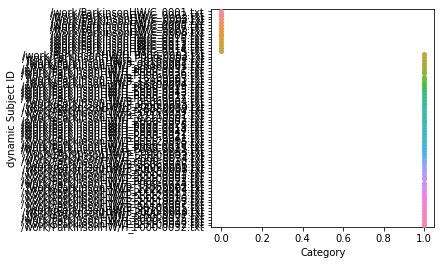

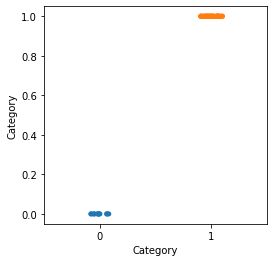

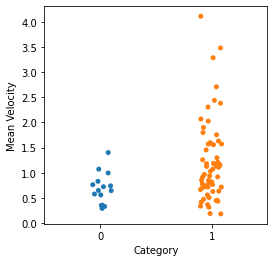

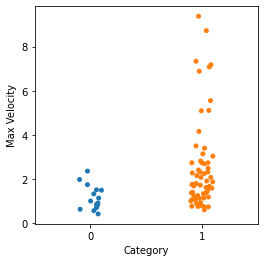

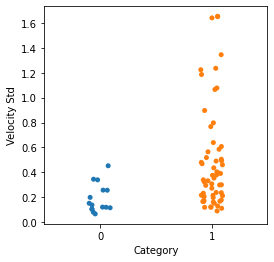

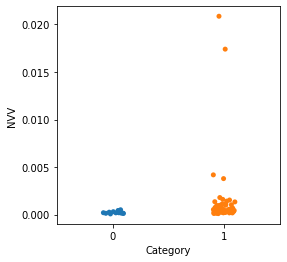

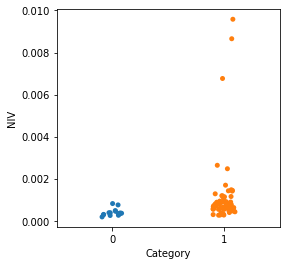

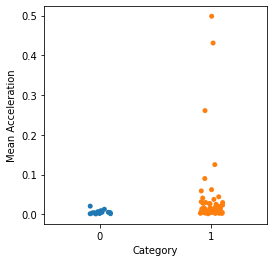

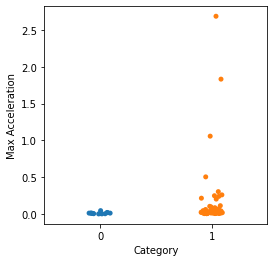

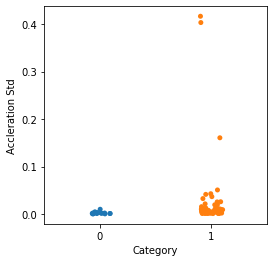

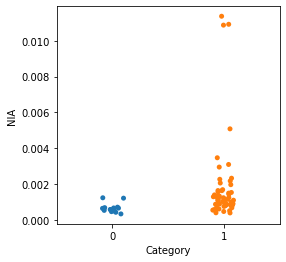

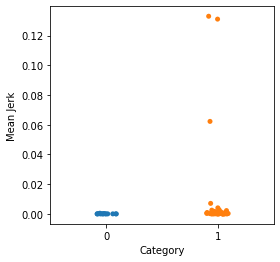

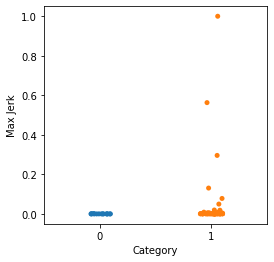

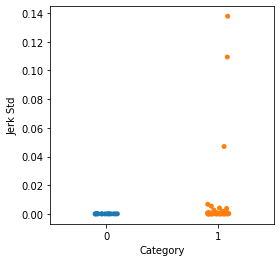

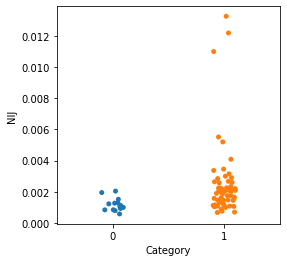

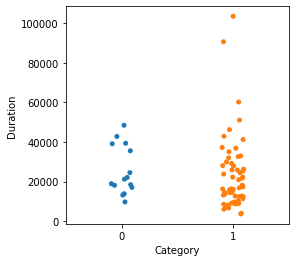

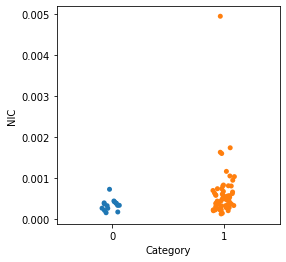

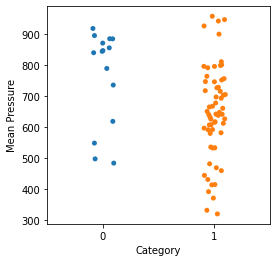

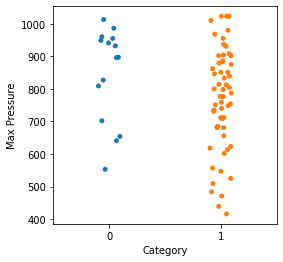

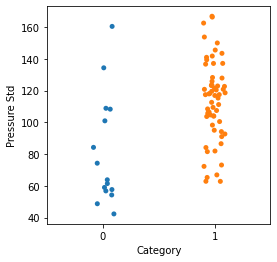

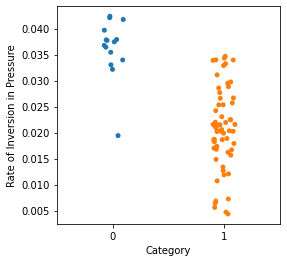

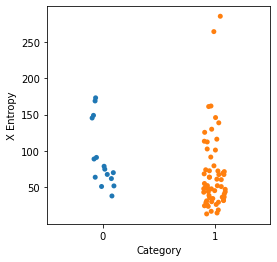

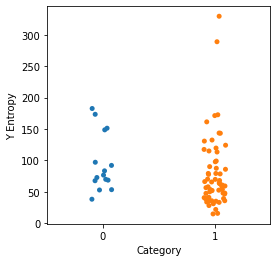

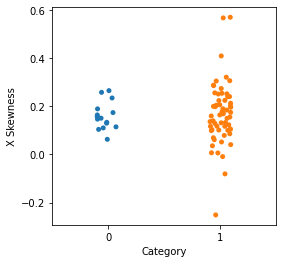

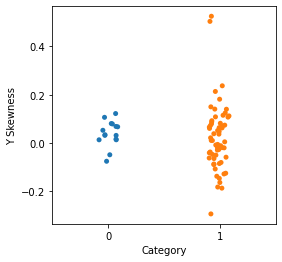

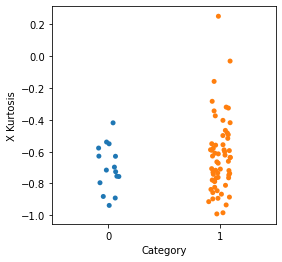

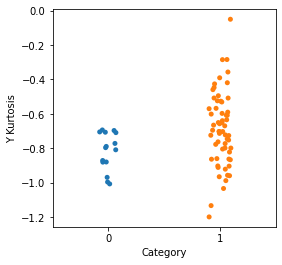

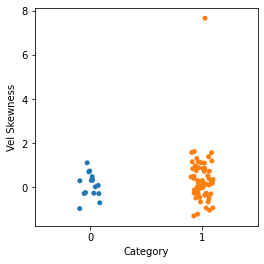

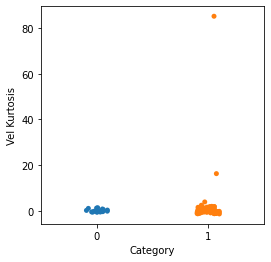

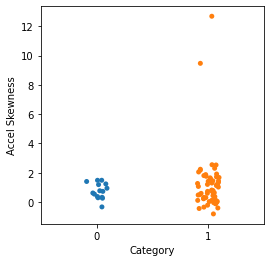

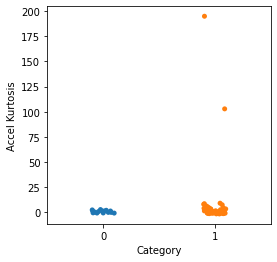

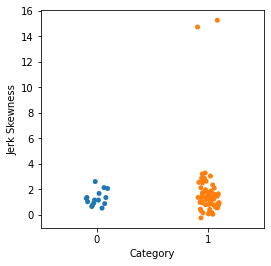

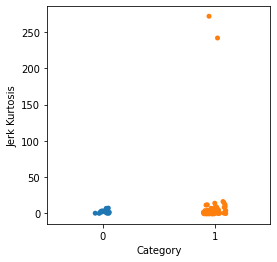

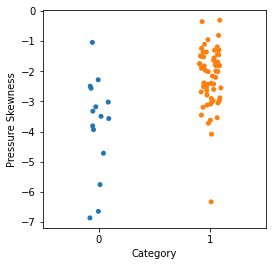

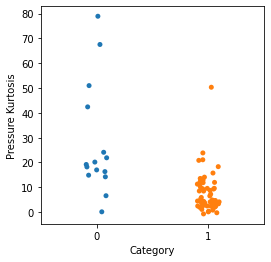

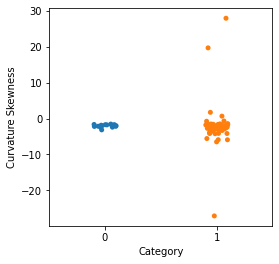

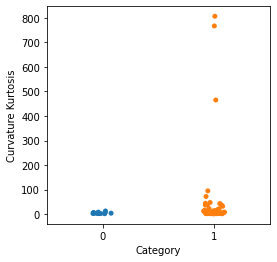

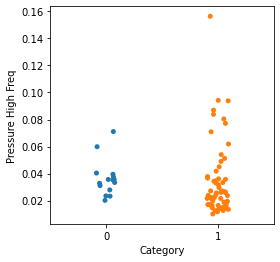

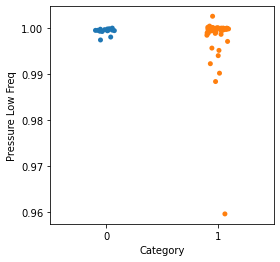

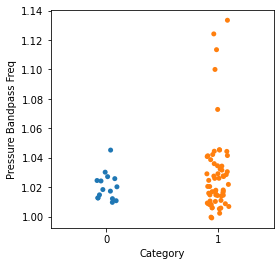

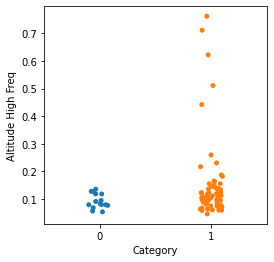

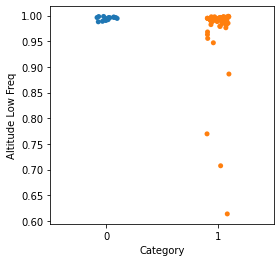

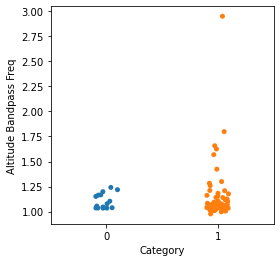

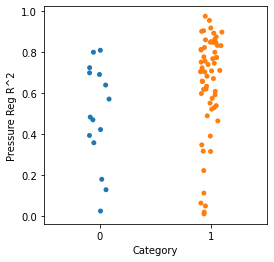

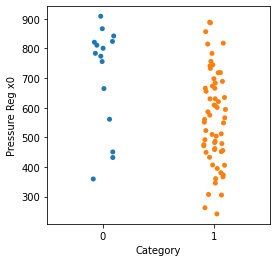

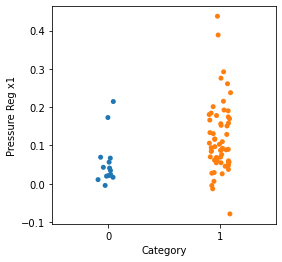

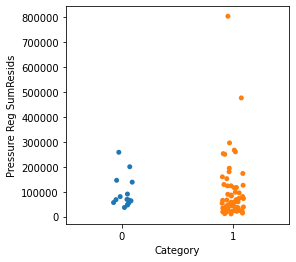

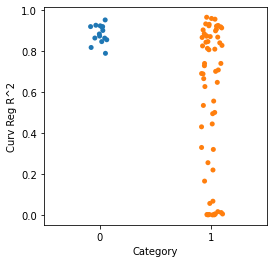

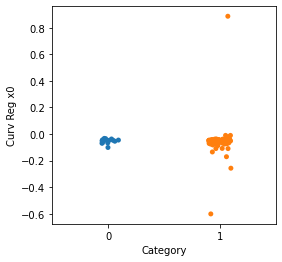

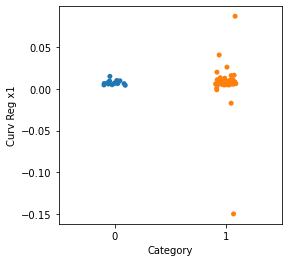

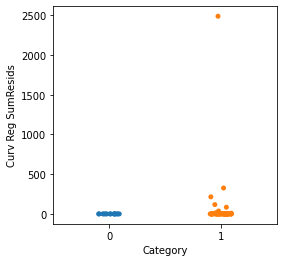

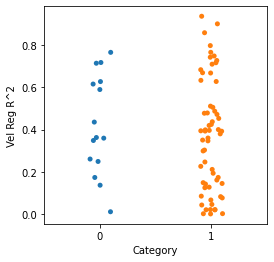

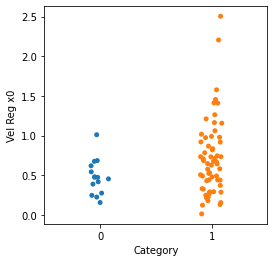

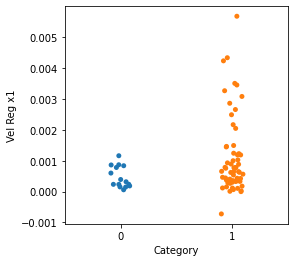

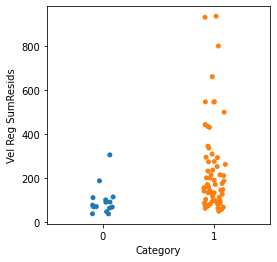

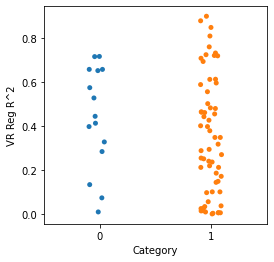

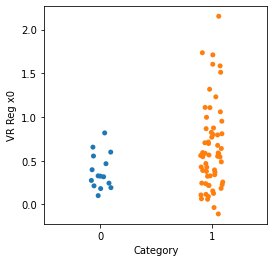

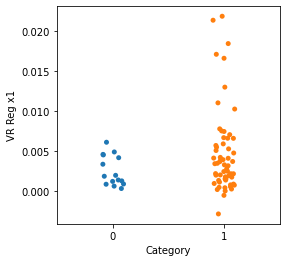

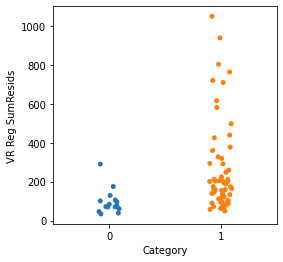

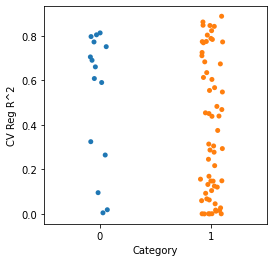

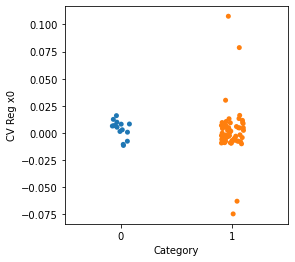

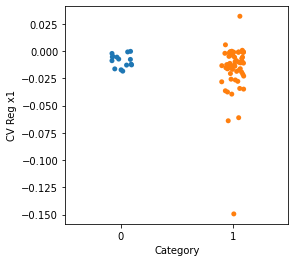

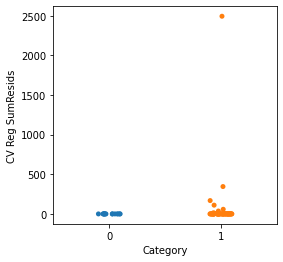

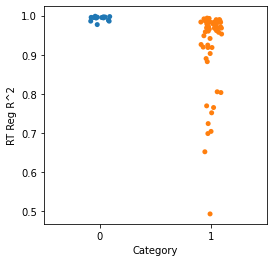

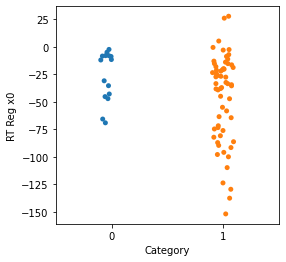

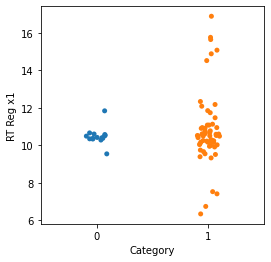

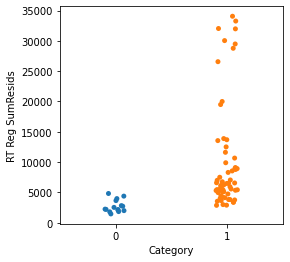

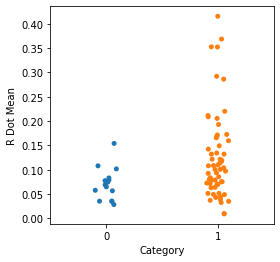

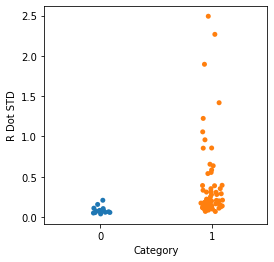

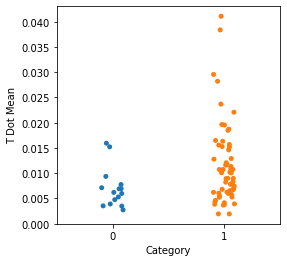

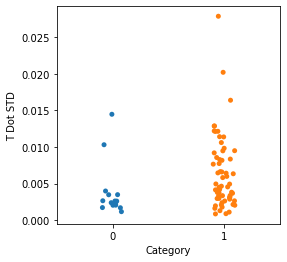

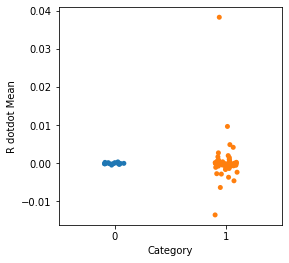

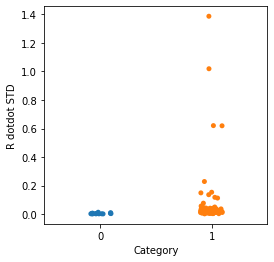

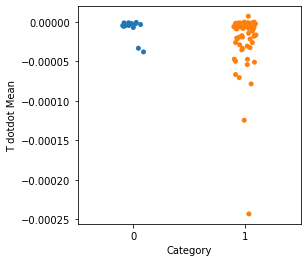

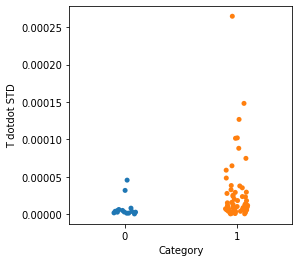

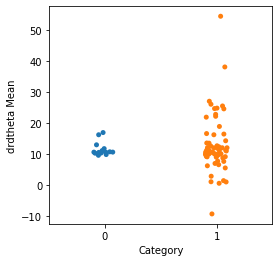

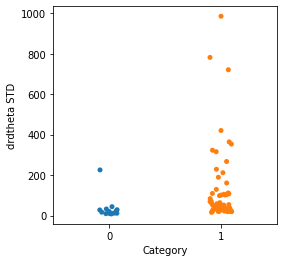

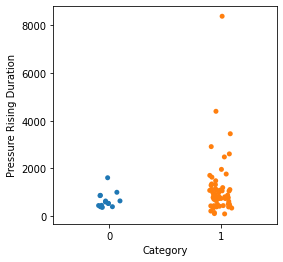

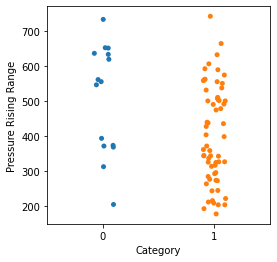

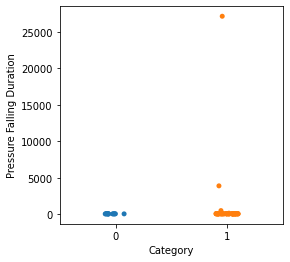

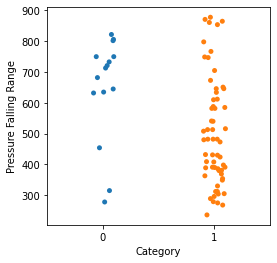

In [ ]:
for i in df_all_features_dynamic[2:]: 
    plt.figure(figsize = (4, 4))
    #plt.title('Strip Plot of {} vs. Category (0 - Control; 1 - Patient)'.format(i), fontsize = 15)
    sns.stripplot(x = df_all_features_dynamic['Category'], y = df_all_features_dynamic[i])

## Feature Selection

In [ ]:
df_all_features_dynamic

,dynamic Subject ID,Category,Mean Velocity,Max Velocity,Velocity Std,NVV,NIV,Mean Acceleration,Max Acceleration,Accleration Std,...,R dotdot Mean,R dotdot STD,T dotdot Mean,T dotdot STD,drdtheta Mean,drdtheta STD,Pressure Rising Duration,Pressure Rising Range,Pressure Falling Duration,Pressure Falling Range
0,/work/ParkinsonHW/C_0001.txt,0,0.763353,1.508147,0.256847,0.000199,0.000386,0.005358,0.012816,0.002136,...,-0.000290,0.003108,-0.000003,0.000004,10.610610,9.597464,387,633,50,822
1,/work/ParkinsonHW/C_0002.txt,0,0.559823,1.001812,0.137363,0.000238,0.000285,0.003091,0.006730,0.001066,...,-0.000100,0.002019,-0.000002,0.000002,10.803881,11.155429,387,561,43,713
2,/work/ParkinsonHW/C_0003.txt,0,0.577474,0.808143,0.119065,0.000142,0.000253,0.002888,0.006152,0.001091,...,0.000180,0.003554,-0.000003,0.000003,11.830677,12.358261,630,636,54,682
3,/work/ParkinsonHW/C_0004.txt,0,0.645112,1.133661,0.151134,0.000251,0.000330,0.004083,0.012296,0.002318,...,-0.000123,0.003338,-0.000005,0.000005,10.404557,15.273382,626,733,42,802
4,/work/ParkinsonHW/C_0005.txt,0,0.995901,1.976179,0.344574,0.000203,0.000360,0.009018,0.018844,0.003200,...,-0.000461,0.003006,-0.000006,0.000006,10.601360,8.134354,584,652,50,733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,/work/ParkinsonHW/P_26060007.txt,1,0.766646,2.073436,0.378668,0.000396,0.000642,0.006019,0.022859,0.003773,...,-0.000338,0.015033,-0.000002,0.000003,13.639552,35.132567,4394,326,63,424
72,/work/ParkinsonHW/H_P000-0035.txt,1,2.026080,9.373600,1.224294,0.017409,0.008655,0.431046,2.685503,0.403142,...,-0.013530,1.386249,-0.000033,0.000038,27.093770,322.825381,614,398,3884,363
73,/work/ParkinsonHW/H_p000-0018.txt,1,0.452617,0.801572,0.169099,0.000637,0.000719,0.003721,0.018696,0.002739,...,-0.000213,0.015425,-0.000003,0.000004,18.972630,70.527852,767,490,42,585
74,/work/ParkinsonHW/P_23100002.txt,1,0.635284,1.069605,0.161262,0.000191,0.000274,0.003823,0.006819,0.001408,...,0.000037,0.004329,-0.000006,0.000007,12.684681,32.778074,1342,632,63,871


In [ ]:
df_all_features_static

,Static Subject ID,Category,Mean Velocity,Max Velocity,Velocity Std,NVV,NIV,Mean Acceleration,Max Acceleration,Accleration Std,...,R dotdot Mean,R dotdot STD,T dotdot Mean,T dotdot STD,drdtheta Mean,drdtheta STD,Pressure Rising Duration,Pressure Rising Range,Pressure Falling Duration,Pressure Falling Range
0,/work/ParkinsonHW/C_0001.txt,0,0.763353,1.508147,0.256847,0.000199,0.000386,0.005358,0.012816,0.002136,...,-0.000290,0.003108,-0.000003,0.000004,10.610610,9.597464,387,633,50,822
1,/work/ParkinsonHW/C_0002.txt,0,0.559823,1.001812,0.137363,0.000238,0.000285,0.003091,0.006730,0.001066,...,-0.000100,0.002019,-0.000002,0.000002,10.803881,11.155429,387,561,43,713
2,/work/ParkinsonHW/C_0003.txt,0,0.577474,0.808143,0.119065,0.000142,0.000253,0.002888,0.006152,0.001091,...,0.000180,0.003554,-0.000003,0.000003,11.830677,12.358261,630,636,54,682
3,/work/ParkinsonHW/C_0004.txt,0,0.645112,1.133661,0.151134,0.000251,0.000330,0.004083,0.012296,0.002318,...,-0.000123,0.003338,-0.000005,0.000005,10.404557,15.273382,626,733,42,802
4,/work/ParkinsonHW/C_0005.txt,0,0.995901,1.976179,0.344574,0.000203,0.000360,0.009018,0.018844,0.003200,...,-0.000461,0.003006,-0.000006,0.000006,10.601360,8.134354,584,652,50,733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,/work/ParkinsonHW/P_26060007.txt,1,0.766646,2.073436,0.378668,0.000396,0.000642,0.006019,0.022859,0.003773,...,-0.000338,0.015033,-0.000002,0.000003,13.639552,35.132567,4394,326,63,424
72,/work/ParkinsonHW/H_P000-0035.txt,1,2.026080,9.373600,1.224294,0.017409,0.008655,0.431046,2.685503,0.403142,...,-0.013530,1.386249,-0.000033,0.000038,27.093770,322.825381,614,398,3884,363
73,/work/ParkinsonHW/H_p000-0018.txt,1,0.452617,0.801572,0.169099,0.000637,0.000719,0.003721,0.018696,0.002739,...,-0.000213,0.015425,-0.000003,0.000004,18.972630,70.527852,767,490,42,585
74,/work/ParkinsonHW/P_23100002.txt,1,0.635284,1.069605,0.161262,0.000191,0.000274,0.003823,0.006819,0.001408,...,0.000037,0.004329,-0.000006,0.000007,12.684681,32.778074,1342,632,63,871


In [ ]:
# df_all_features_dynamic
# df_all_features_static
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#feature_cols = df_all_features_static.columns[2:].values
#Xcols = df_all_features_static.loc[:, feature_cols]
#ycols = df_all_features_static.Category

feature_cols = df_all_features_dynamic.columns[2:].values
Xcols = df_all_features_dynamic.loc[:, feature_cols]
ycols = df_all_features_dynamic.Category

[0.00683868 0.01451211 0.01036296 0.01090196 0.01227685 0.01348686
 0.0031739  0.00563559 0.01582024 0.01030725 0.00959588 0.00151552
 0.00572081 0.0068228  0.00606869 0.02649689 0.01010912 0.04273294
 0.10406696 0.00759726 0.00351807 0.00504405 0.00746358 0.00658928
 0.01102357 0.0081096  0.00469135 0.00509805 0.00526191 0.00242462
 0.00645684 0.04081331 0.03879252 0.00384718 0.01280092 0.00716999
 0.00927683 0.00516167 0.00403367 0.00422927 0.00749985 0.01343203
 0.02809095 0.01880722 0.00545935 0.02318537 0.00457146 0.00237443
 0.00455247 0.00750265 0.00268573 0.00369411 0.01095535 0.00687405
 0.0042611  0.00711247 0.01046921 0.01034985 0.00463739 0.00432488
 0.00502217 0.03568671 0.01384025 0.0098336  0.03545812 0.00954289
 0.03866475 0.0135518  0.0135272  0.00320687 0.00964913 0.00514677
 0.01975255 0.01093753 0.01046854 0.01520861 0.01343438 0.00728086
 0.0330978 ]


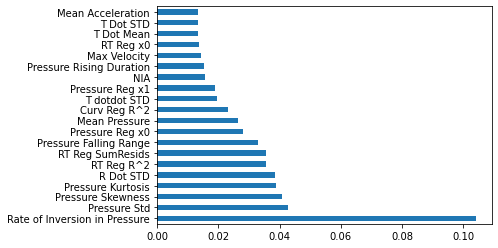

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(Xcols,ycols)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=Xcols.columns)
#print(feat_importances)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

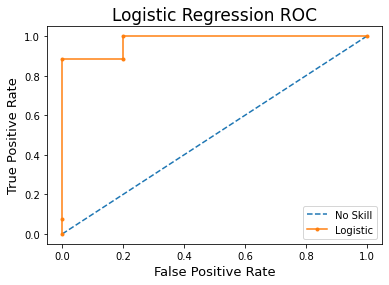

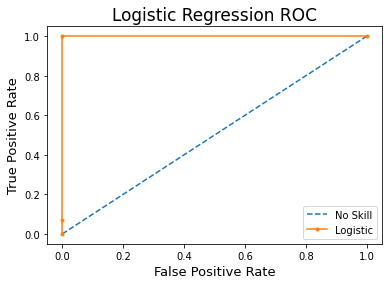

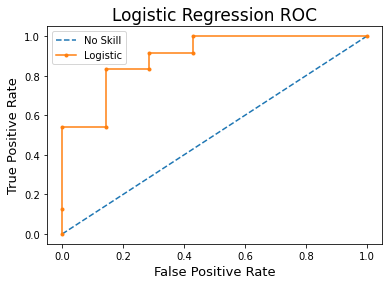

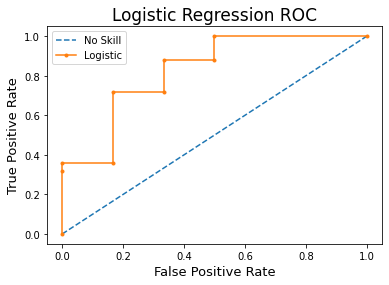

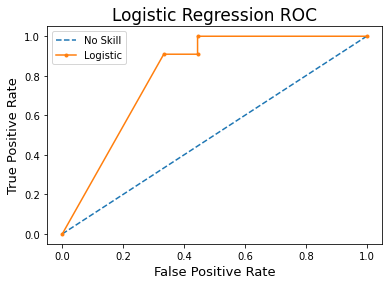

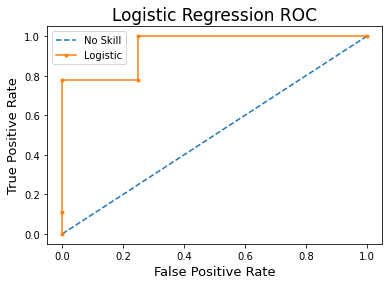

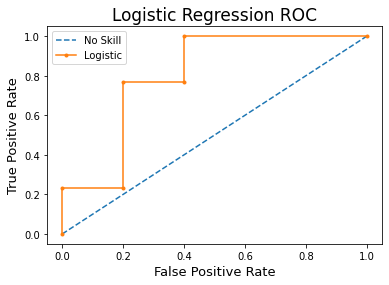

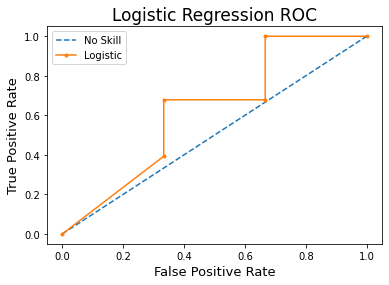

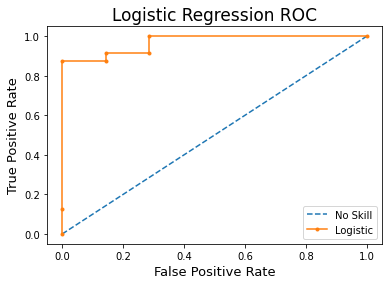

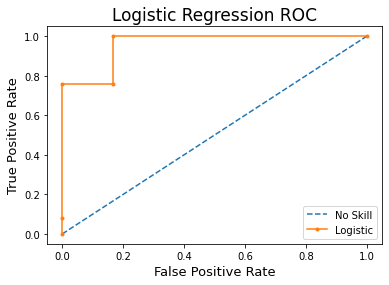

In [ ]:
# 1. import
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import roc_curve

# 2. instantiate model

'''List of different feature sets to use: '''
# feature_cols = df_all_features_static.columns[2:].values
# feature_cols = ['Rate of Inversion in Pressure', 'Pressure Kurtosis', 'Pressure Skewness', 'Pressure Std'']
# feature_cols = ['RT Reg SumResids', 'Pressure Reg x1', 'Curv Reg R^2', 'Pressure Reg x0', 'VR Reg SumResids', 'RT Reg R^2']
feature_cols = ['RT Reg SumResids', 'R Dot STD', 'RT Reg R^2', 'R dotdot STD', 'T Dot STD', 'drdtheta STD']

X = df_all_features_dynamic.loc[:, feature_cols].values
y = df_all_features_dynamic.Category.values

model_log_aucs = []

for i in range((10)): 
    trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.4, random_state=i)

    logreg = LogisticRegression(solver='lbfgs', max_iter = 1200000)

    # 3. fit 
    logreg.fit(trainX, trainy)

    pred_class = logreg.predict(testX)
    pred_probs = logreg.predict_proba(testX)
    pred_probs = pred_probs[:, 1]

    # 4. calculate scores

    # generate a no skill prediction (majority class)
    random_probs = [1 for _ in range(len(testy))]

    random_auc = roc_auc_score(testy, random_probs)
    model_log_auc = roc_auc_score(testy, pred_probs)
    model_log_aucs.append(model_log_auc)

    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(testy, random_probs)
    lr_fpr, lr_tpr, _ = roc_curve(testy, pred_probs)

    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

    # axis labels
    pyplot.xlabel('False Positive Rate', fontsize = 13)
    pyplot.ylabel('True Positive Rate', fontsize = 13)
    pyplot.title('Logistic Regression ROC', fontsize = 17)

    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

In [ ]:
print(model_log_aucs)
print(np.mean(model_log_auc))

[0.976923076923077, 1.0, 0.8988095238095237, 0.8266666666666667, 0.8080808080808081, 0.9444444444444444, 0.8, 0.625, 0.9702380952380952, 0.96]
0.96


### SVM

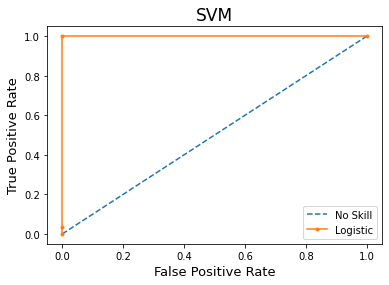

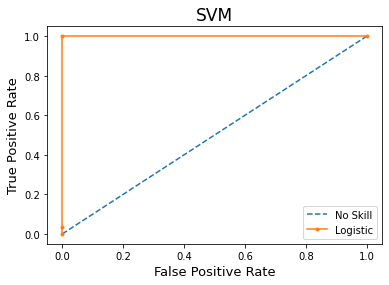

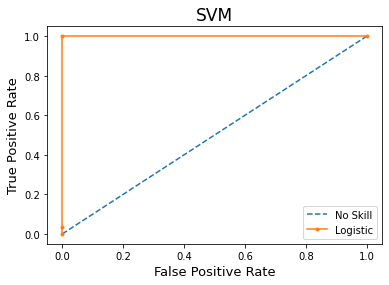

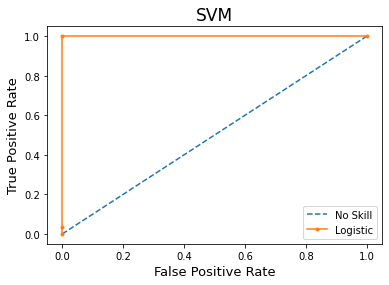

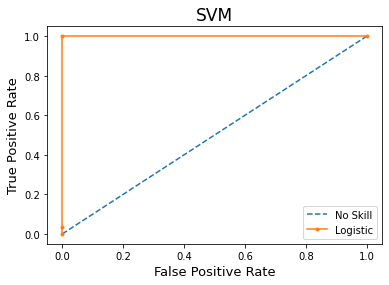

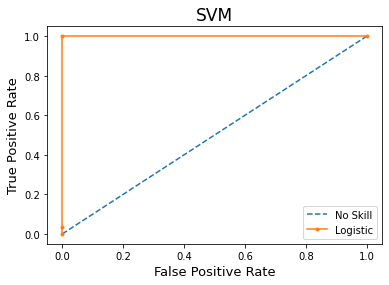

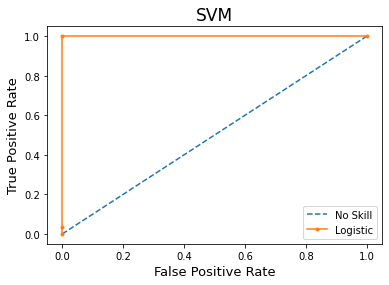

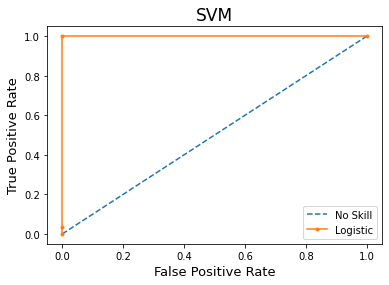

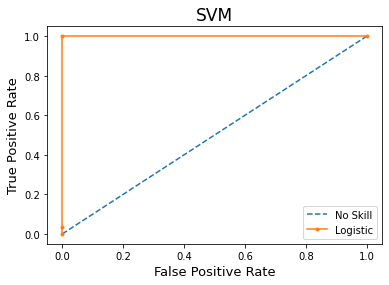

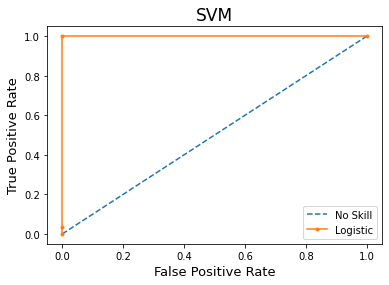

In [ ]:
from sklearn.svm import SVC

'''List of different feature sets to use: '''
# feature_cols = df_all_features_static.columns[2:].values
feature_cols = df_all_features_dynamic.columns[2:].values

# feature_cols = ['Rate of Inversion in Pressure', 'Pressure Kurtosis', 'Pressure Skewness', 'Pressure Std'']
# feature_cols = ['RT Reg SumResids', 'Pressure Reg x1', 'Curv Reg R^2', 'Pressure Reg x0', 'VR Reg SumResids', 'RT Reg R^2']
# feature_cols = ['RT Reg SumResids', 'R Dot STD', 'RT Reg R^2', 'R dotdot STD', 'T Dot STD', 'drdtheta STD']

model_svm_aucs = []
for i in range(10): 
    trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.4, random_state=1)

    svclassifier = SVC(kernel='linear', probability = True)

    svclassifier.fit(trainX, trainy)

    pred_class = svclassifier.predict(testX)
    pred_probs = svclassifier.predict_proba(testX)
    pred_probs = pred_probs[:, 1]


    # generate a no skill prediction (majority class)
    random_probs = [1 for _ in range(len(testy))]

    random_auc = roc_auc_score(testy, random_probs)
    model_svm_auc = roc_auc_score(testy, pred_probs)
    model_svm_aucs.append(model_svm_auc)

    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(testy, random_probs)
    lr_fpr, lr_tpr, _ = roc_curve(testy, pred_probs)

    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

    # axis labels
    pyplot.xlabel('False Positive Rate', fontsize = 13)
    pyplot.ylabel('True Positive Rate', fontsize = 13)
    pyplot.title('SVM', fontsize = 17)

    # show the legend
    pyplot.legend()

    # show the plot
    pyplot.show()

In [ ]:
print(model_svm_aucs)
print(np.mean(model_svm_aucs))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
1.0


In [ ]:
from scipy.stats import mannwhitneyu
dfDynamicControls = df_all_features_dynamic[df_all_features_dynamic['Category'] == 0]
dfDynamicPatient = df_all_features_dynamic[df_all_features_dynamic['Category'] == 1]

dfStaticControls = df_all_features_static[df_all_features_static['Category'] == 0]
dfStaticPatient = df_all_features_static[df_all_features_static['Category'] == 1]

PValArrDynamic = []
MWUStatArrDynamic = []

PValArrStatic = []
MWUStatArrStatic = []

for i in df_all_features_dynamic.columns[2:]: 
    MWUStatArrDynamic.append(mannwhitneyu(dfDynamicControls[i], dfDynamicPatient[i], alternative = 'two-sided')[0])
    PValArrDynamic.append(mannwhitneyu(dfDynamicControls[i], dfDynamicPatient[i], alternative = 'two-sided')[1])

for i in df_all_features_static.columns[2:]: 
    MWUStatArrStatic.append(mannwhitneyu(dfStaticControls[i], dfStaticPatient[i], alternative = 'two-sided')[0])
    PValArrStatic.append(mannwhitneyu(dfStaticControls[i], dfStaticPatient[i], alternative = 'two-sided')[1])

print(MWUStatArrDynamic)
print(PValArrDynamic)
print(MWUStatArrStatic)
print(PValArrStatic)

#for i in dfDynamicPatient.columns[2:]:

#print(sum(df_all_features_dynamic['Category'] == 0))

#print(df.head())
#print((df.shape))
#df_all_features_static

[249.0, 203.0, 183.0, 141.0, 132.0, 192.0, 139.0, 145.0, 158.0, 120.0, 104.0, 104.0, 168.0, 574.0, 288.0, 660.0, 586.5, 188.0, 862.0, 651.0, 605.0, 442.0, 526.0, 395.0, 265.0, 405.0, 490.0, 432.0, 454.0, 429.0, 448.0, 165.0, 793.0, 558.0, 281.0, 605.0, 353.0, 409.0, 301.0, 623.0, 495.0, 273.0, 676.0, 204.0, 533.0, 705.0, 494.0, 444.0, 176.0, 506.0, 308.0, 306.0, 176.0, 547.0, 310.0, 350.0, 176.0, 567.0, 565.0, 522.0, 183.0, 860.0, 599.0, 430.0, 45.0, 256.0, 73.0, 271.0, 261.0, 485.0, 69.0, 652.0, 230.0, 451.0, 137.0, 292.0, 650.0, 272.0, 665.0]
[0.006636562709765133, 0.0009168092446353925, 0.00034902603782800185, 3.723006763211768e-05, 2.2204438943674017e-05, 0.0005433077846866823, 3.3228466017528136e-05, 4.664583914332034e-05, 9.533516724172415e-05, 1.0920513746647285e-05, 4.087032299820326e-06, 4.087032299820326e-06, 0.00016216500849568766, 0.13005517121840438, 0.027413917907561897, 0.008382871021080705, 0.0935030100064549, 0.0004470198768439352, 1.3458237805518004e-07, 0.01177587460

In [ ]:
min (PValArrDynamic)

7.577939003964034e-08

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=54ea7590-1f30-42ee-b9c1-c929b94e3f2f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>